In [ ]:
!pip3 install pysindy

# Clase 9 - Reconstrucción
**2do Cuatrimestre 2020**

**DF - FCEyN - UBA**

En este Notebook aprenderemos a a encontrar las ecuaciones diferenciales de un sistema a partir de la serie temporal de sus variables.

## 1) Preparación del Dataset

En esta priemr parte, vamos a trabajar con datos generados a partir de un sistema de Lorenz.

### 1.1) Simulación: Atractor de Lorenz

Simulamos el sistema utilizando el método de Runge-Kutta.

In [ ]:
# Imports de utilidades de Python

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Definición de las funciones a utilizar

def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6


def ecuaciones(X,t, sig = 10.0, b = 8.0/3.0, ro = 28.0):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''

    x,y,z = X

    x_dot = sig * ( y - x )
    y_dot = x * (ro - z) - y
    z_dot = x * y - b * z
    
    return [x_dot, y_dot, z_dot]


def integrar_ecuaciones(total_time,dt,X0):

    '''
    Recibe:
       total_time: Tiempo total del integración
       dt: Paso temporal (h del método)
       X0: Lista con [x0,y0] valores iniciales de la integración
       params: Lista con los parámetros del sistema
    Devuelve:
       x_s, y_s: Vectores con las soluciones para ambas variables
       num_steps: Numero de pasos de integracion
    '''

    num_steps = int(np.divide(total_time,dt))

    # Empty vectors
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    zs = np.empty(num_steps)

    # Set initial values
    xs[0], ys[0], zs[0] = X0

    t = 0.0

    # Integramos con método de Euler
    for i in range(num_steps-1):
        xs[i + 1], ys[i + 1], zs[i + 1] = rk4(ecuaciones,[xs[i], ys[i], zs[i]],t,dt)
        t += dt

    return xs, ys, zs, num_steps

Ahora si, definimos los parametros de la intergación, integramos y ploteamos las soluciones.

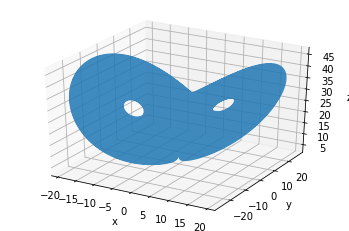

In [ ]:
# Parámetros de integración

total_time = 5000
dt = 0.005
X0 = (5, 0, 10)

# Simulamos los datos

x_total, y_total, z_total, num_steps_total = integrar_ecuaciones(total_time,dt,X0)
num_steps = int(num_steps_total - num_steps_total*0.2)
x, y, z = x_total[-num_steps:], y_total[-num_steps:], z_total[-num_steps:]


# Ploteamos las soluciones
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(x, y, z, alpha=0.85)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 1.2) Calculo de derivadas y diccionario de funciones

Para realizar la regresión Lasso precisamos no solo contar con la serie temporal de las varables, sino también con su derivada temporal. Para calcularla vamos a usar la función `gradient()` de numpy. Pueden encontrar el algoritmo númerico que utiliza para calcularlas [en su documentación](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html).

In [ ]:
# Computamos la derivadas
# Noten que es preciso multiplicar normalizar por el paso temporal
x_deriv = np.gradient(x) * (1.0/dt)
y_deriv = np.gradient(y) * (1.0/dt)
z_deriv = np.gradient(z) * (1.0/dt)

# Lo unimos en una única matriz con el shape adecuado
mat_derivadas = np.asarray([x_deriv,y_deriv,z_deriv]).T
print(mat_derivadas.shape)

(800000, 3)


Ademas de las derivadas, también precisamos acomodar en la matriz `theta` los términos polinomicos que vamos a utilizar.

In [ ]:
x.shape[0]

800000

In [ ]:
# Definimos la matriz vacia
theta=np.zeros((x.shape[0],10)) #x.shape[0] es el numero de pasos temporales = 800000

# Completamos con los términos correspondientes
theta[:,0]=np.ones_like(x)
theta[:,1]=x
theta[:,2]=y
theta[:,3]=z
theta[:,4]=x*x
theta[:,5]=x*y
theta[:,6]=x*z
theta[:,7]=y*y
theta[:,8]=y*z
theta[:,9]=z*z

# Para luego comparar con los resultados obtenidos, definimos estas listas
terminos = ['1','x','y','z','xx','xy','xz','yy','yz','zz']
real_x_coef = [0,-10,10,0,0,0,0,0,0,0]
real_y_coef = [0,28,-1.0,0,0,0,-1.0,0,0,0]
real_z_coef = [0,0,0,-2.67,0,1.0,0,0,0,0]

**Observación:** Realizamos el calculo de los atributos polinómicos de manera manual para transparentar el proceso. Pero existen soluciones de librerias, como `PolynomialFeatures` de `sklearn`, que lo realizan de manera automática (cosa que puede resultar muy comoda, en especial para ordenes mas altos).

## 2) Reconstrucción de las ecuaciones con Lasso

In [ ]:
from IPython.display import Image
Image(url='https://media.tenor.com/images/783541733d62d72c20790d1f5d9ca70d/tenor.gif')

Sabemos que el sistema de ecuaciones que buscamos usualmente cuenta con una cantidad limitad de terminos no nulos. Para evitar un `overfitting` donde se activen muchos términos en las ecuaciones, utilizamos técnicas de regularización en la regresión. 

Una de las técnicas de regularización mas utilizadas es la de sumar el módulo del valor de los coeficientes del modelo a la función de costo. Esto se conoce como regularización **Lasso** o **$L_1$** (por la norma).


### 2.1) Primer Lasso

La librería Scikit-Learn cuenta varias implementaciones de este tipo de regresiónes lineales con regularización. Primero vamos a utilizar la regresión Lasso clásica, [aquí su documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).


In [ ]:
from sklearn import linear_model

# Definimos el modelo
lasso = linear_model.Lasso(alpha=0.2,max_iter=100000,fit_intercept=False,normalize=False)

Noten que, al definir la matriz theta, agregamos una columna de unos como primer columna. De esta forma el primer coeficiente de cada ecuación corresponde al término independiente de la misma. Es por esto que debemos setear `fit_intercept=False` al definir el modelo.

In [ ]:
# Realizamos el ajuste
lasso.fit(theta,mat_derivadas)

Inspeccionemos el valor numerico de los resultados:

In [ ]:
print('Coeficientes en x:')
print(lasso.coef_[0,:])
print('\n')
print('Coeficientes en y:')
print(lasso.coef_[1,:])
print('\n')
print('Coeficientes en z:')
print(lasso.coef_[2,:])


Para comparar los resultados obtenidos con los coeficientes originales, vamos a graficarlos.

In [ ]:
rango = np.arange(len(lasso.coef_[0,:]))
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.scatter(rango,real_x_coef, label='Real',s=100)
plt.scatter(rango,lasso.coef_[0,:], label='Ajuste',s=100,marker="P")
plt.xticks(rango, terminos)
plt.xlabel('Coeficientes dx/dt')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.subplot(1,3,2)
plt.scatter(rango,real_y_coef, label='Real',s=100)
plt.scatter(rango,lasso.coef_[1,:], label='Ajuste',s=100,marker="P")
plt.xticks(rango, terminos)
plt.xlabel('Coeficientes dy/dt')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.subplot(1,3,3)
plt.scatter(rango,real_z_coef, label='Real',s=100)
plt.scatter(rango,lasso.coef_[2,:], label='Ajuste',s=100,marker="P")
plt.xticks(rango, terminos)
plt.xlabel('Coeficientes dz/dt')
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.show()

**El valor de los parametros con Sindy siempre son subestimados por el termino de regularizacion. Si el coeficiente posta era 3, Sindy me da 2.7. Si el coeficiente posta era -4, Sindy me da -3.7.**

**Discutir:** 

*   ¿Sobrevivieron únicamente los terminos originales?
*   Observando el valor de los coeficientes en los términos que se corresponden con los de las ecuaciones originales, ¿Nota alguna particularidad?

### 2.2) Lasso - Variando Alpha

Una pregunta interesante para hacerse es: **¿Cómo elegir el hiperparámetro alpha?**

No hay un valor óptimo universal para el hiperparametro alpha, depende del dataset con el que estemos trabajando. Recuerden que normalmente no vamos a tener las ecuaciones reales para contrastar (de hecho estas ecuaciones son precisamente lo que estamos buscando). 

Una forma válida de elegir el hiperparámetro es definir el número máximo de terminos que pretendemos que aparezcan en nuestras ecuaciones. Pero, siendo que no conmocemos la cantidad mínima de terminos relevantes, esta desición resulta arbitraria. 

Otra forma es entrenar el modelo para distintos valores de alpha y evaluar la performance del modelo sobre un set distinto al de entrenamiento (test set). Esperamos que el modelo encontrado con el valor mas adecuado de alpha generalice mejor a los datos de test.



In [ ]:
# Generamos un vector con los valores de alpha a explorar
alphas = np.logspace(-4, 1, 20)
print(alphas)

Separamos los datos en un set de entrenamieto y uno de prueba.

In [ ]:
# Proporcion entre train y test
proporcion = 0.8

# Indice de separacion entre train y test
indice_test = int(proporcion * num_steps)

# Separamos la matriz Theta en 2 partes, una para el train set y otra para el test set.
theta_train = theta[:indice_test]
theta_test = theta[indice_test:]

# Hacemos lo mismo con las derivadas
x_deriv_train = x_deriv[:indice_test]
x_deriv_test = x_deriv[indice_test:]
y_deriv_train = y_deriv[:indice_test]
y_deriv_test = y_deriv[indice_test:]
z_deriv_train = z_deriv[:indice_test]
z_deriv_test = z_deriv[indice_test:]

**Atención:** Por una cuestión de simplicidad y velocidad, vamos a realizar el análisis solo para la ecaución correspondiente a la varaible $x$. Pero el mismo analisis puede aplicarse a todo el sistema completo.

Para cada valor de alhpa, entrenamos un modelo sobre el traing set y lo evaluamos en el test set (en terminos del `mean_squared_error` y del `mean_absolute_error`).

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Preparamos las listas donde vamos a guardar los datos
errores_absolute = []
errores_squared = []
coeficientes = []

# Recorremos los distintos valores de alpha
for value in alphas:
    print('Calculando con alpha = ', value)
    lasso = linear_model.Lasso(alpha=value, max_iter=100000,fit_intercept=False,normalize=False)
    lasso.fit(theta_train,x_deriv_train)
    x_deriv_test_predict = lasso.predict(theta_test)
    
    # Guadamos los coeficientes encontrados
    coeficientes.append(lasso.coef_)

    # Computamos el error cometido con 2 métricas distintas
    error_absolute = mean_absolute_error(x_deriv_test_predict,x_deriv_test)
    error_squared = mean_squared_error(x_deriv_test_predict,x_deriv_test)
    
    # Guardamos el error
    errores_absolute.append(error_absolute)
    errores_squared.append(error_squared)

Grafiquemos el error en función del parámetro alpha.  

In [ ]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas,errores_absolute, label='Error Absoluto')
plt.semilogx(alphas,errores_squared, label='Error Cauidrático')
plt.ylim(0,1)
plt.ylabel('Mean Absolute Error - Test set')
plt.xlabel('Alpha')
plt.grid(True)
plt.legend()
plt.show()

**Ejercicio:** ¿Qué valor de alpha eligirían? Recuerden que, por lo general, un parametro alpha mas grande corresponde a un modelo mas simple, con menos terminos no nulos.

**Eligiria un alfa cercano a 10^-2.**

Por último vamos a graficar cómo varían los coeficientes a medida que variamos el valor de regularización.

In [ ]:
plt.figure(figsize=(10,6))
coef_mat = np.asarray(coeficientes).T
for i in range(coef_mat.shape[0]):
    ter = terminos[i]
    plt.semilogx(alphas,coef_mat[i],label=ter)
plt.ylabel('Valor del coeficiente')
plt.xlabel('Alpha')
plt.grid(True)
# plt.ylim(-0.05,0.05) # Luego descomenten esta linea para hacer zoom
plt.show()

**Los parametros que mas varian su valor cuando muevo el alpha son los que posta estan en el sistema de ecuaciones original. Por ejemplo para el x de Lorenz son "y" y "x".**

**Ejercicio:** Repita el proceso realizado, pero esta vez para la ecuación correspondiente a la variable $z$.

**Observaciones:**
*  En este caso, donde contamos con una gran cantidad de datos simulados, este tipo de analisis resulta válido. Pero, si la cantidad de datos disponibles para realizar la regresión fuese menor o mas ruidosa, sería necesario realizar un proceso de cros-validación para encontrar el hiperparámetro adecuado. 

*  Una vez que encontaron cuales son los terminos que sobreviven en el valor de alpha óptimo, una buena estrategia podría ser volver a realizar una regresión, pero esta vez utilizando únicamente estos términos y reduciendo (o directamente anulando) el peso de la regularización (alpha). Este proceso normalmente mejora el valor de los coeficientes obtenidos. Parte de esta idea es lo que motiva al método de la próxima sección.


**Ejercicio:** Pruebe cambiar el modelo a `sklearn.linear_model.Ridge` , que utiliza regularización tipo Ridege ($L_2$) en lugar de Lasso. Observe para este caso como se reducen los coeficientes en funcion de parametro de penalización.


## 3) Reconstrucción de las ecuaciones con Sindy

Sindy es una librería de python dedicada a la identificación de sistemas dinamicos a partir de datos. La librería contiene varias utilizades dedicadas a este fin, entre ellas podemos destacar:
*   Distintos tipos de *sparse regressions*.
*   Funciones para computar features extras.
*   Funciones para computar derivadas de señales.

La característica mas importante de la librería es un tipo de regresión llamada **Sequentially thresholded least squares** ([Aqui su código](https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/stlsq.html)). Este algotritmo es muy parecido al proceso que realizamos en la sección anterior pero con la diferencia que usa una regularización tipo Ridge (los coeficientes entran en la función de costo elevados al cuadrado) y que el algoritmo va *apagando* automáticamente los términos inferiores a cierto *treshold*.


### 3.1) *Structure of PySINDy* - de la documentación

The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

$$ \dot X \approx \Theta(X)\Xi. $$

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.

### 3.2) Implmentación

La principal ventaja de utilizar esta librería es la simplicidad con la que se puede implementar la regresión. Noten que, a diferencia de lo que hicimos en la sección anterior, la librería calcula las derivadas y los términos polinómicos automáticamente.

In [ ]:
import pysindy as ps

# Hiperparámetros
poly_order = 2
threshold = 0.05
alpha=0.1

# Definición del modelo
model = ps.SINDy(
    # Elegimos el optimizador a utilizar
    optimizer=ps.STLSQ(threshold=threshold,alpha=alpha),
    # Elegimos los features (términos de las escuaciones) a utilizar
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    # Le ponemos un nombre a las variables
    feature_names = ['x', 'y', 'z']
)

# Adecuamos nuestros datos en la matriz 'data'
data = np.asarray([x,y,z]).T

# En la primer dimensión van los pasos temporales y en la segunda las varables
print(data.shape)


Finalmente entrenamos el modelo:

In [ ]:
# Entrenamiento
model.fit(data, t=dt)

model.print()

Noten que los terminos con los que sobrevivieron en las ecuaciones son los correctos y, además, los valores numéricos de los coeficientes encontrados son increiblermente cercanos al los del sistema original!

Por último, podemos usar la misma libreria para integrar el modelo encontrado y comparar las soluciones con las del sistema original.

In [ ]:
# Definimos el vector de Tiempos
tiempos = np.arange(0,100,dt)
# Integramos el sistema encontrado durante ese timepo
data_sim = model.simulate(data[0], tiempos)

In [ ]:
# Graficamos las soluciones
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(data_sim[:,0], data_sim[:,1], data_sim[:,2], alpha=0.85)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz de las ecuaciones encontradas')
plt.show()

## 4) Big Trouble in Little Van Der Pol 
Siendo que funcionaron tan bien en un atractor caótico, a esta altura resulta muy tentador pensar que esta calse de métodos funcionaran bien en caulquier tipo de sistemas. 

Definamos un nuevo dataset a partir del siguiente sistema de ecuaciones:


In [ ]:
def van_der_pol(X,t, mu = 7.0):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''

    x,y = X

    x_dot = y
    y_dot = mu * (1 - x * x) * y - x
    
    return [x_dot, y_dot]

Integramos usando odeint:

In [ ]:
from scipy.integrate import odeint

dt = 0.4
t_train = np.arange(0, 500, dt)
x0_train = [-2, 0]
x_train = odeint(van_der_pol, x0_train, t_train)

Grafiquemos como lucen las soluciones:

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_train[:,0],x_train[:,1],'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Diagrama de Fases')
plt.subplot(1,2,2)
# plt.plot(t_train[:100],x_train[:100,1],'-o')
plt.plot(t_train[:100],x_train[:100,0],'-o')
plt.xlabel('Tiempo')
plt.ylabel('x')
plt.title('Evolucion de x(t)')
plt.show()

Este es un oscilador de relajación muy popular llamado oscilador de **Van Der Pol**, cuyas ecuaciones son:

$$ 
	\begin{bmatrix} \frac{dx}{dt} \\ \frac{dy}{dt} \end{bmatrix}
	= \begin{bmatrix} y \\ -x + \mu y - \mu x^2y  \end{bmatrix}
$$


La dinámica en este caso no es muy compleja: un único termino cúbico y 3 terminos lineales dan lugar a una solución de tipo ciclo limite. 

Además, contamos con mas de 35 samples por cada oscilación y ni siquiera estamos agregando ruido. Si pensamos en un escenario experimental, este sería un caso practicamente ideal.

**Ejercicio:** 

*   Pruebe variar los hiperparametros *treshold* y *alpha* y explore los sistemas encontrados para este simple sistema dinamico.

*   ¿Coinciden los terminos encontrado con los del sistema original? ¿Son cualitativamente similares las soluciones?

*   ¿Cuál les parece que puede ser la causa de este desempeño?

*   Cambie el valor del parámetro $\mu$ en la función `val_der_pol()` de $\mu = 7$ a $\mu = 1$ y vuelva a realizar el ejercicio. ¿Mejora o emperoa la capacidad de reproducir las ecuaciones del sistema? ¿Qué cambió?

In [ ]:
import pysindy as ps

# Hiperparámetros
poly_order = 3
threshold = 0.05
alpha=0.1

# Definición del modelo
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold,alpha=alpha),
    feature_library=ps.PolynomialLibrary(degree=poly_order,include_bias=True),
    feature_names = ['x', 'y']
)

# En la primer dimensión van los pasos temporales y en la segunda las varables
print(data.shape)


In [ ]:
# Entrenamiento
model.fit(x_train, t=dt)

model.print()

Si graficamos las soluciones del sistema encontrado contra las del sistema original:

In [ ]:
x_train_sim = model.simulate(x0_train, t_train)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_train[:,0],x_train[:,1],'o')
plt.plot(x_train_sim[:,0],x_train_sim[:,1],'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Diagrama de Fases')
plt.xlim(-2.5,2.5)
plt.subplot(1,2,2)
# plt.plot(t_train[:100],x_train[:100,1],'-o')
plt.plot(t_train[:100],x_train[:100,0],'-o')
plt.plot(t_train[:100],x_train_sim[:100,0],'-o')
plt.xlabel('Tiempo')
plt.ylabel('x')
plt.title('Evolucion de x(t)')
plt.show()

El problema del Van der Pool es que involucra diferencias de escalas temporales: hay partes muy rapidas y muy lentas, y ahi es donde la derivada pega saltos/picos y cuando voy a calcular la derivada numericamente esto es un problema. En estos casos Sindy no anda super bien. Por la escala temporal de que hay partes donde el sistema salta de una rama a la otra de ese sistema bi-estable, las derivadas dan problemas  y Sindy puede quedarse trabado y tener dificultades en la reconstruccion del campo vector. 

Es importante que en tu sampleo de la senial temporal que le metes a Sindy tenga un buen sampleo del espacio de fases. Por ejemplo, suma mucho si a Sindy le incluis el transitorio de la solucion. Los puntos que le metes a Sindy tienen que estar bien distribuidos en tu espacio de fases, tienen que llenar todo el espacio de fases. Sindy tambien funciona mejor si tengo varios experimentos con diferentes condiciones iniciales. 

**El problema del Van der pool con mu=7 se soluciona bajando el dt. Cuando aumento el mu, el sistema tiene una transicion rapida, tengo saltos. Necesito un sampleo temporal muy fino sino al calcular la derivada numericamente con un dt pobre hace que de todo mal.** 

**Hay veces que no puedo bajar el sampling rate (el dt) o bajar el mu, entonces ahi Sindy anda mal.**

